# 5. Analyzing Chocolate Data

In this chapter we are going to analyze the [Chocolate Bar Ratings](https://www.kaggle.com/datasets/evangower/chocolate-bar-ratings) dataset. Our main focus will be to see the factors that affect the rating of the Chocolate Bars. So using tools learned in the previous chapters, we will get some insights in this dataset.

## Set Up

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd


data_dir = 'data/'

# this is to silence pandas' warnings
import warnings
warnings.simplefilter(action='ignore')
    
%matplotlib inline
%config InlineBackend.figure_format='svg'

#constant variables needed for the configuration of plots' appereance
FONT_SCALE = 1.3
FONT_FAMILY = 'DejaVu Sans'

## Load the data

Here we load the dataset.

In [3]:
chocolate_dataset = pd.read_csv(data_dir+'chocolate_bars.csv')
chocolate_dataset.columns

Index(['id', 'manufacturer', 'company_location', 'year_reviewed',
       'bean_origin', 'bar_name', 'cocoa_percent', 'num_ingredients',
       'ingredients', 'review', 'rating'],
      dtype='object')

In [4]:
# checking some of the columns
chocolate_dataset.head()[['manufacturer', 'company_location', 'bean_origin','rating']]

,manufacturer,company_location,bean_origin,rating
0,5150,U.S.A.,Tanzania,3.25
1,5150,U.S.A.,Dominican Republic,3.50
2,5150,U.S.A.,Madagascar,3.75
3,5150,U.S.A.,Fiji,3.00
4,5150,U.S.A.,Venezuela,3.00


In [5]:
countries = pd.read_csv(data_dir+'country_coordinates.csv')
countries.head()

,bean_origin,latitude,longitude
0,Tanzania,-6.369028,34.888822
1,Dominican Republic,18.735693,-70.162651
2,Madagascar,-18.766947,46.869107
3,Fiji,-16.578193,179.414413
4,Venezuela,6.423750,-66.589730


As we can see, the dataset has 11 columns:
- **`id`** - is the ID of the review for the chocolate bar. 
- **`manufacturer`** - refers to the manufacturer of the chocolate bar. 
- **`company_location`** shows the location of the manufacturer. 
- **`year_reviewed`** - stands for the year of the review of the chocolate bar. 
- **`bean_origin`** - is the origin of the cocoa bean. 
- **`bar_name`** - stands for the company that provides cocoa beans. 
- **`cocoa_percent`** - shows the cocoa percentage of the bars. 
- **`num_ingredients`** and **`ingredients`**  - show the ingredients of the chocolate bars. 
- **`review`** and **`rating`** - capture interviewees' opinions on the chocolate bars.

Now let's analyze this dataset.

## 5.1 Analyzing the data

In order for the comparisons to be relevant, we will consider only the top 30 manufacturers that have received the most ratings. It is not fair to compare a manufacturer that has received 5 ratings with one that has received 50 ratings. In other words, the average ratings of these two manufacturers may not lead us to relevant insights. 

In [6]:
#here we find the top 30 companies with the most ratings
ratings_per_manufacturer = chocolate_dataset[['id', 'manufacturer']] \
    .groupby('manufacturer').count().reset_index() \
    .sort_values(by='id', ascending=False).iloc[:30,:]

#here we select the ratings for the manufacturers that have received the most
selection = chocolate_dataset['manufacturer'].isin(ratings_per_manufacturer['manufacturer'])
manufacturers_with_most_ratings = chocolate_dataset.loc[selection, :]

### 5.1.1 Number of ratings per manufacturer

Let us start by checking how many ratings there are per manufacturer. This will help us get an insight later on when we compare the average ratings per manufacturer to see how relevant they will be.

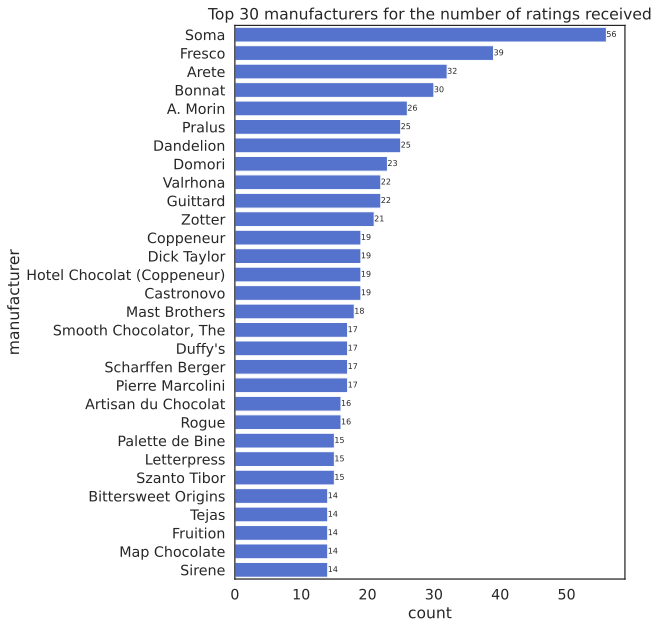

In [7]:
#plot the results
sns.set(rc={'figure.figsize': (7, 10), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    # seaborn's countplot
    ax = sns.countplot(
        data=manufacturers_with_most_ratings,
        y='manufacturer',
        order=manufacturers_with_most_ratings['manufacturer'].value_counts().index,
        color='royalblue' 
    )

    #use this command to display the average for each manufacturers
    ax.bar_label(ax.containers[0], size=8)
    
    ax.set_title('Top 30 manufacturers for the number of ratings received')

### 5.1.2 Average rating per manufacturer

Now we will use a `boxplot` to check the ratings of the most rated manufacturers.

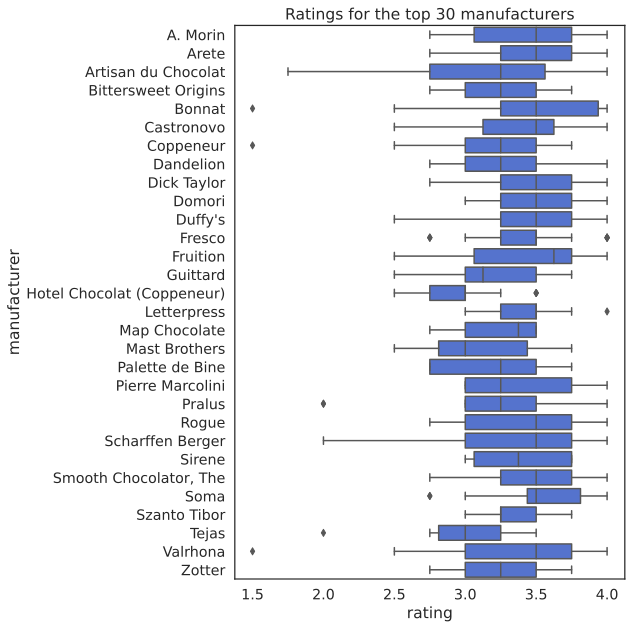

In [8]:
#plot the results
sns.set(rc={'figure.figsize': (7, 10), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    # seaborn's boxplot
    ax = sns.boxplot(
        data=manufacturers_with_most_ratings,
        x='rating',
        y='manufacturer',
        color='royalblue'
    )
    
    ax.set_title('Ratings for the top 30 manufacturers')

### 5.1.3 Distribution of ratings per location of most voted manufacturers

Now we want to find out the distribution of ratings for the countries where chocolate bars that received the most reviews came from.

In [9]:
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, label, fontweight="bold", color=color,
      ha="left", va="center", transform=ax.transAxes)

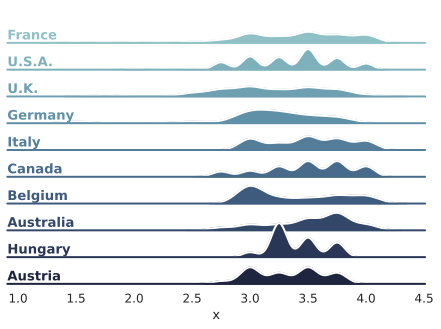

In [10]:
# plotting distribution of ratings per location of most voted manufacturers

data = manufacturers_with_most_ratings[['company_location', 'rating']]
g = data.iloc[:, 0] # country
x = data.iloc[:, 1] # rating
df = pd.DataFrame(dict(x=x, g=g))
    
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'font.family': [FONT_FAMILY]})
with sns.plotting_context("notebook", font_scale=1.1):
        #initialize the FacetGrid object
        pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
        g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

        #draw the densities in a few steps
        g.map(sns.kdeplot, "x",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
        g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

        # passing color=None to refline() uses the hue mapping
        g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

        g.map(label, "x")

        # Set the subplots to overlap
        g.figure.subplots_adjust(hspace=-.25)

        # Remove axes details that don't play well with overlap
        g.set_titles("")
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True)

### 5.1.4 Average rating per bean origin

Now we are going to find the ratings per bean origin. The map will show us which countries produce the best beans, always according to the ratings of people. For this we are going to use a scatter plot on top of a map with the help of the `geopandas` library.

In [11]:
# Finding average rating per location
ratings_per_bean_origin = pd.merge(chocolate_dataset[['bean_origin', 'rating']], 
                                   countries, 
                                   on='bean_origin') \
                         .groupby('bean_origin').mean().round(2) \
                         .reset_index() \
                         .sort_values(by='rating', ascending=False)

# Getting world map from geopandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

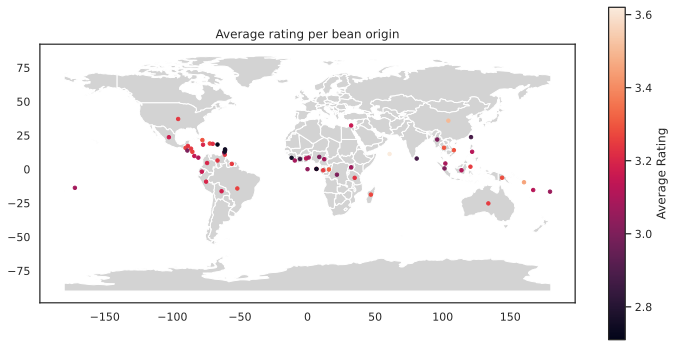

In [12]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

plt.scatter(x=ratings_per_bean_origin.longitude, 
            y=ratings_per_bean_origin.latitude,
            c=ratings_per_bean_origin.rating,
            s=12)
plt.colorbar(label='Average Rating')
plt.title('Average rating per bean origin')
plt.show()

### 5.1.5 Correlogram of cocoa percentage, number of ingredients and rating

As we can see from the correlogram below, there is no correlation between the ratings and the cocoa percent or the number of ingredients in the chocolate bar.

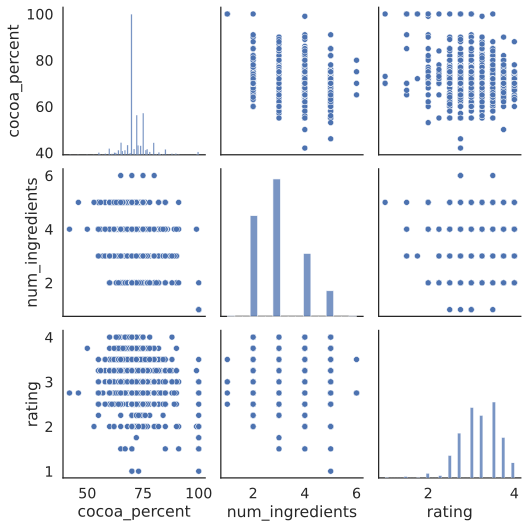

In [13]:
selected_data = chocolate_dataset[['cocoa_percent', 'num_ingredients','rating']]

sns.set(rc={'figure.figsize':(6, 8), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE): 
    sns.pairplot(selected_data, kind="scatter", palette="Set2")
    plt.show()

Another way to get insights about any correlation among variables is to visualize the correlation matrix as an annotated heatmap.

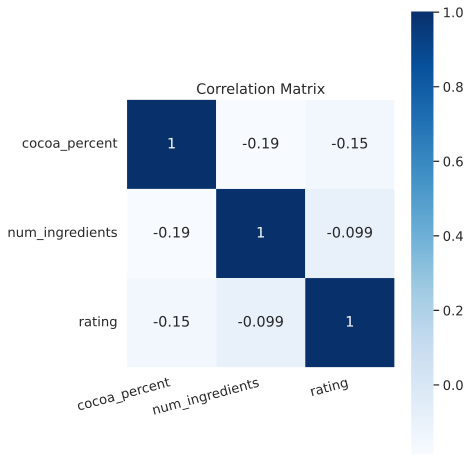

In [14]:
sns.set(rc={'figure.figsize':(6, 8), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=1.2):
    correlation_matrix = selected_data.corr()
    ax = sns.heatmap(data=correlation_matrix,
                cmap='Blues',
                annot=True,
                square=True)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=15,
        horizontalalignment='right'
    )
    ax.set_title('Correlation Matrix')

And this brings us to  the end of this tutorial. In the next chapter there will be some similar exercises to check your knowledge and understanding.